In [130]:
import json
import pathlib
import os
import sys  
sys.path.insert(0, '/nethome/bdevnani3/flash1/long_tail_lang/')
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm.notebook import trange, tqdm
from os import listdir
from os.path import isfile, join


from classes import CLASSES, CUSTOM_TEMPLATES, GENERIC_PROMPT_COLLECTIONS
from utils import *

In [131]:
from data_loader import dataloaders, classes
from clip import clip

In [132]:
dataset_path = '/nethome/bdevnani3/flash1/long_tail_lang/datasets/ImageNet/'
dataset = 'ImageNet_LT'
split = "train"

In [133]:
dl = dataloaders.load_data(data_root= dataset_path, dataset=dataset, phase=split, batch_size=512)

Loading data from /nethome/bdevnani3/flash1/long_tail_lang/data/ImageNet_LT/ImageNet_LT_train.txt
Use data transformation: Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.5, 1), ratio=(0.75, 1.3333), interpolation=bicubic)
    RandomHorizontalFlip(p=0.5)
    ColorJitter(brightness=[0.6, 1.4], contrast=[0.6, 1.4], saturation=[0.6, 1.4], hue=None)
    ToTensor()
    Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])
)
***********************DATASET: train None
train 115846
No sampler.
Shuffle is True.


In [134]:
# Initialize CLIP models 
class TextEncoder(nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        self.transformer = clip_model.transformer
        self.positional_embedding = clip_model.positional_embedding
        self.ln_final = clip_model.ln_final
        self.text_projection = clip_model.text_projection
        self.dtype = clip_model.dtype
        self.token_embedding = clip_model.token_embedding

    def forward(self, text):
        x = self.token_embedding(text).type(self.dtype)  # [batch_size, n_ctx, d_model]

        x = x + self.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.ln_final(x).type(self.dtype)

        # x.shape = [batch_size, n_ctx, transformer.width]
        # take features from the eot embedding (eot_token is the highest number in each sequence)
        x = x[torch.arange(x.shape[0]), text.argmax(dim=-1)] @ self.text_projection

        return x

def load_clip_to_cpu(visual_backbone):
    backbone_name = visual_backbone
    url = clip._MODELS[backbone_name]
    model_path = clip._download(url, os.path.expanduser("~/.cache/clip"))

    try:
        # loading JIT archive
        model = torch.jit.load(model_path, map_location="cpu").eval()
        state_dict = None

    except RuntimeError:
        state_dict = torch.load(model_path, map_location="cpu")

    model = clip.build_model(state_dict or model.state_dict())

    return model

# Regular CLIP model
clip_model = load_clip_to_cpu("RN50")

visual_model = torch.nn.DataParallel(clip_model.visual).cuda()

text_model = TextEncoder(clip_model)
text_model = torch.nn.DataParallel(text_model).cuda()

In [135]:
# Small cyclip model
cyclip_small_model = load_clip_to_cpu("RN50")
checkpoint = torch.load("/nethome/bdevnani3/flash1/CyCLIP/data/pretrained_cyclip/best.pt", map_location = "cuda")
state_dict = checkpoint["state_dict"]
state_dict = {key[len("module."):]: value for key, value in state_dict.items()}
cyclip_small_model.load_state_dict(state_dict)
cyclip_small_visual_model = torch.nn.DataParallel(cyclip_small_model.visual).cuda()

cyclip_small_text_model = TextEncoder(cyclip_small_model)
cyclip_small_text_model = torch.nn.DataParallel(cyclip_small_text_model).cuda()

In [136]:
# Small clip model
clip_small_model = load_clip_to_cpu("RN50")
checkpoint = torch.load("/nethome/bdevnani3/flash1/CyCLIP/data/pretrained_clip/best.pt", map_location = "cuda")
state_dict = checkpoint["state_dict"]
state_dict = {key[len("module."):]: value for key, value in state_dict.items()}
clip_small_model.load_state_dict(state_dict)
clip_small_visual_model = torch.nn.DataParallel(clip_small_model.visual).cuda()

clip_small_text_model = TextEncoder(clip_small_model)
clip_small_text_model = torch.nn.DataParallel(clip_small_text_model).cuda()

In [185]:
total_preds = []
total_labels = []
total_pred_values = []
with torch.no_grad():
    for inp, label, index, path in tqdm(dl[0]):
        classnames = CLASSES
        templates = GENERIC_PROMPT_COLLECTIONS["default"][0]

        texts = torch.cat([clip.tokenize(templates.format(c)) for c in classnames])
        texts = texts.cuda()
        zeroshot_weights = text_model(texts).float()
        zeroshot_weights = zeroshot_weights / zeroshot_weights.norm(
            dim=-1, keepdim=True
        )

        y = visual_model(inp.half()).float()
        x = y
        x = x / x.norm(dim=-1, keepdim=True)

        logits = 100.0 * x @ zeroshot_weights.t()
        pred_vals, preds = torch.max(logits, 1)
        total_preds.append(torch2numpy(preds))
        total_labels.append(torch2numpy(label))
        total_pred_values.append(torch2numpy(pred_vals))
    
    total_preds = np.hstack(total_preds)
    total_labels = np.hstack(total_labels)
    total_pred_values = np.hstack(total_pred_values)
    acc_mic_top1 = (total_preds == total_labels).sum().item() / len(total_labels)
    print("Accuracy:",  acc_mic_top1*100)

  0%|          | 0/227 [00:00<?, ?it/s]

Accuracy: 56.8359375


In [177]:
total_preds = []
total_labels = []
with torch.no_grad():
    for inp, label, index, path in tqdm(dl[0]):
        classnames = CLASSES
        templates = GENERIC_PROMPT_COLLECTIONS["default"][0]

        texts = torch.cat([clip.tokenize(templates.format(c)) for c in classnames])
        texts = texts.cuda()
        zeroshot_weights = clip_small_text_model(texts).float()
        zeroshot_weights = zeroshot_weights / zeroshot_weights.norm(
            dim=-1, keepdim=True
        )

        y = clip_small_visual_model(inp.half()).float()
        x = y
        x = x / x.norm(dim=-1, keepdim=True)

        logits = 100.0 * x @ zeroshot_weights.t()
        pred_vals, preds = torch.max(logits, 1)
        total_preds.append(torch2numpy(preds))
        total_labels.append(torch2numpy(label))
        break
    
    total_preds = np.hstack(total_preds)
    total_labels = np.hstack(total_labels)
    acc_mic_top1 = (total_preds == total_labels).sum().item() / len(total_labels)
    print("Accuracy:",  acc_mic_top1*100)

  0%|          | 0/227 [00:00<?, ?it/s]

Accuracy: 18.75


In [179]:
total_preds = []
total_labels = []
with torch.no_grad():
    for inp, label, index, path in tqdm(dl[0]):
        classnames = CLASSES
        templates = GENERIC_PROMPT_COLLECTIONS["default"][0]

        texts = torch.cat([clip.tokenize(templates.format(c)) for c in classnames])
        texts = texts.cuda()
        zeroshot_weights = cyclip_small_text_model(texts).float()
        zeroshot_weights = zeroshot_weights / zeroshot_weights.norm(
            dim=-1, keepdim=True
        )

        y = cyclip_small_visual_model(inp.half()).float()
        x = y
        x = x / x.norm(dim=-1, keepdim=True)

        logits = 100.0 * x @ zeroshot_weights.t()
        pred_vals, preds = torch.max(logits, 1)
        total_preds.append(torch2numpy(preds))
        total_labels.append(torch2numpy(label))

    
    total_preds = np.hstack(total_preds)
    total_labels = np.hstack(total_labels)
    acc_mic_top1 = (total_preds == total_labels).sum().item() / len(total_labels)
    print("Accuracy:",  acc_mic_top1*100)

  0%|          | 0/227 [00:00<?, ?it/s]

Accuracy: 22.8515625


In [82]:
dl = dataloaders.load_data(data_root= dataset_path, dataset=dataset, phase=split, batch_size=1)

Loading data from /nethome/bdevnani3/flash1/long_tail_lang/data/ImageNet_LT/ImageNet_LT_train.txt
Use data transformation: Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.5, 1), ratio=(0.75, 1.3333), interpolation=bicubic)
    RandomHorizontalFlip(p=0.5)
    ColorJitter(brightness=[0.6, 1.4], contrast=[0.6, 1.4], saturation=[0.6, 1.4], hue=None)
    ToTensor()
    Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])
)
***********************DATASET: train None
train 115846
No sampler.
Shuffle is True.


In [83]:
# CYCLIP images

cls = "goldfish"

cyclip_image_embs = []
cnt = 0
with torch.no_grad():
    for inp, label, index, path in tqdm(dl[0]):
        if cnt > 50:
            break
        classnames = CLASSES
        templates = GENERIC_PROMPT_COLLECTIONS["default"][0]
        
        if CLASSES[label.item()] == cls:

            y = cyclip_small_visual_model(inp.half()).float()
            x = y
            x = x / x.norm(dim=-1, keepdim=True)

            cyclip_image_embs.append(x)
            cnt+=1

cyclip_image_embs = torch.cat(cyclip_image_embs, dim=0)
cyclip_image_embs.shape

# CYCLIP texts

cls = "goldfish"

cyclip_text_embs = []
templates = GENERIC_PROMPT_COLLECTIONS["ImageNet"]
with torch.no_grad():
    texts = torch.cat([clip.tokenize(template.format(cls)) for template in templates])
    texts = texts.cuda()
    zeroshot_weights = cyclip_small_text_model(texts).float()
    zeroshot_weights = zeroshot_weights / zeroshot_weights.norm(
        dim=-1, keepdim=True
    )

cyclip_text_embs = zeroshot_weights
cyclip_text_embs.shape

# CLIP images

cls = "goldfish"

clip_image_embs = []
cnt = 0
with torch.no_grad():
    for inp, label, index, path in tqdm(dl[0]):
        if cnt > 50:
            break
        classnames = CLASSES
        templates = GENERIC_PROMPT_COLLECTIONS["default"][0]
        
        if CLASSES[label.item()] == cls:

            y = clip_small_visual_model(inp.half()).float()
            x = y
            x = x / x.norm(dim=-1, keepdim=True)

            clip_image_embs.append(x)
            cnt+=1

clip_image_embs = torch.cat(clip_image_embs, dim=0)
clip_image_embs.shape

# CLIP texts

cls = "goldfish"

clip_text_embs = []
templates = GENERIC_PROMPT_COLLECTIONS["ImageNet"]
with torch.no_grad():
    texts = torch.cat([clip.tokenize(template.format(cls)) for template in templates])
    texts = texts.cuda()
    zeroshot_weights = clip_small_text_model(texts).float()
    zeroshot_weights = zeroshot_weights / zeroshot_weights.norm(
        dim=-1, keepdim=True
    )

clip_text_embs = zeroshot_weights
clip_text_embs.shape

  0%|          | 0/115846 [00:00<?, ?it/s]

torch.Size([51, 1024])

In [ ]:
tsne_inp = torch.vstack([cyclip_image_embs, cyclip_text_embs, clip_image_embs, clip_text_embs]).cpu()

In [119]:
# Concatenate everything

# CYCLIP images

cls = "umbrella"

cyclip_image_embs = []
cnt = 0
with torch.no_grad():
    for inp, label, index, path in tqdm(dl[0]):
        if cnt > 50:
            break
        classnames = CLASSES
        templates = GENERIC_PROMPT_COLLECTIONS["default"][0]
        
        if CLASSES[label.item()] == cls:

            y = cyclip_small_visual_model(inp.half()).float()
            x = y
            x = x / x.norm(dim=-1, keepdim=True)

            cyclip_image_embs.append(x)
            cnt+=1

cyclip_image_embs = torch.cat(cyclip_image_embs, dim=0)
cyclip_image_embs.shape

# CYCLIP texts

cyclip_text_embs = []
templates = GENERIC_PROMPT_COLLECTIONS["ImageNet"]
with torch.no_grad():
    texts = torch.cat([clip.tokenize(template.format(cls)) for template in templates])
    texts = texts.cuda()
    zeroshot_weights = cyclip_small_text_model(texts).float()
    zeroshot_weights = zeroshot_weights / zeroshot_weights.norm(
        dim=-1, keepdim=True
    )

cyclip_text_embs = zeroshot_weights
cyclip_text_embs.shape

# CLIP images

clip_image_embs = []
cnt = 0
with torch.no_grad():
    for inp, label, index, path in tqdm(dl[0]):
        if cnt > 50:
            break
        classnames = CLASSES
        templates = GENERIC_PROMPT_COLLECTIONS["default"][0]
        
        if CLASSES[label.item()] == cls:

            y = clip_small_visual_model(inp.half()).float()
            x = y
            x = x / x.norm(dim=-1, keepdim=True)

            clip_image_embs.append(x)
            cnt+=1

clip_image_embs = torch.cat(clip_image_embs, dim=0)
clip_image_embs.shape

# CLIP texts

clip_text_embs = []
templates = GENERIC_PROMPT_COLLECTIONS["ImageNet"]
with torch.no_grad():
    texts = torch.cat([clip.tokenize(template.format(cls)) for template in templates])
    texts = texts.cuda()
    zeroshot_weights = clip_small_text_model(texts).float()
    zeroshot_weights = zeroshot_weights / zeroshot_weights.norm(
        dim=-1, keepdim=True
    )

clip_text_embs = zeroshot_weights
clip_text_embs.shape

  0%|          | 0/115846 [00:00<?, ?it/s]

  0%|          | 0/115846 [00:00<?, ?it/s]

torch.Size([82, 1024])

In [121]:
tsne_inp = torch.vstack([tsne_inp.cuda(), cyclip_image_embs, cyclip_text_embs, clip_image_embs, clip_text_embs]).cpu()

In [124]:
import numpy as np
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, perplexity=50).fit_transform(tsne_inp)
X_embedded.shape

/nethome/bdevnani3/flash1/miniconda3/envs/ltr/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/nethome/bdevnani3/flash1/miniconda3/envs/ltr/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(532, 2)

In [127]:
from sklearn.manifold import TSNE
from keras.datasets import mnist
from sklearn.datasets import load_iris
from numpy import reshape
import seaborn as sns
import pandas as pd  
sns.set(rc={'figure.figsize':(11.7,8.27)})


<AxesSubplot:>

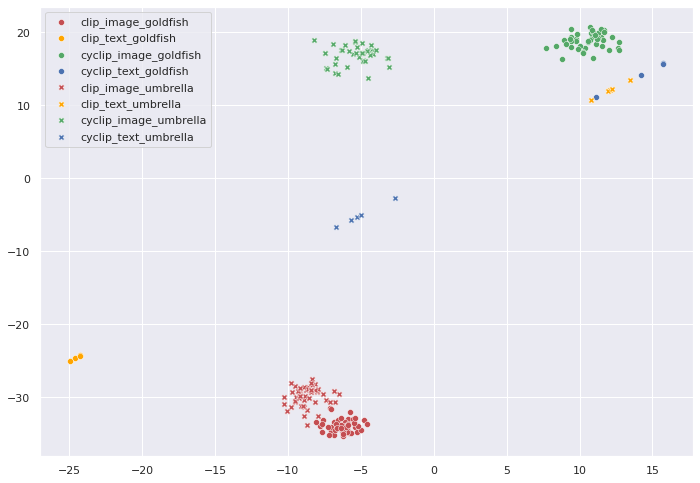

In [129]:
sns.scatterplot(x=X_embedded[:50, 0], y=X_embedded[:50, 1], color = "r", label="clip_image_goldfish")
sns.scatterplot(x=X_embedded[51:55, 0], y=X_embedded[51:55, 0], color = "orange", label="clip_text_goldfish")
sns.scatterplot(x=X_embedded[135:180, 0], y=X_embedded[135:180, 1], color = "g", label="cyclip_image_goldfish")
sns.scatterplot(x=X_embedded[183:187, 0], y=X_embedded[183:187, 0], color = "b", label="cyclip_text_goldfish")

sns.scatterplot(x=X_embedded[266:316, 0], y=X_embedded[266:316, 1], color = "r", label="clip_image_umbrella", marker = "X")
sns.scatterplot(x=X_embedded[317:322, 0], y=X_embedded[317:322, 0], color = "orange", label="clip_text_umbrella", marker = "X")
sns.scatterplot(x=X_embedded[450:490, 0], y=X_embedded[450:490, 1], color = "g", label="cyclip_image_umbrella", marker = "X")
sns.scatterplot(x=X_embedded[-5:, 0], y=X_embedded[-5:, 0], color = "b", label="cyclip_text_umbrella", marker = "X")

Why isn't cyclip able to get the benefits of boosting?

In [184]:
templates = GENERIC_PROMPT_COLLECTIONS["ImageNet"]

In [194]:
avg_preds = 0
count = 0
with torch.no_grad():
    for inp, labels, index, path in tqdm(dl[0]):
        classnames = np.array(CLASSES)
        templates = GENERIC_PROMPT_COLLECTIONS["default"][0]
        
        classnames = classnames[labels.cpu()]

        texts = torch.cat([clip.tokenize(templates.format(c)) for c in classnames])
        texts = texts.cuda()
        zeroshot_weights = text_model(texts).float()
        zeroshot_weights = zeroshot_weights / zeroshot_weights.norm(
            dim=-1, keepdim=True
        )

        y = visual_model(inp.half()).float()
        x = y
        x = x / x.norm(dim=-1, keepdim=True)

        logits = x @ zeroshot_weights.t()
        logits =  logits.cuda() * torch.eye(len(inp),len(inp)).cuda()
        avg_preds += logits.sum()
        count += len(inp)
    
    print("Avg similarity:",  avg_preds/count)

  0%|          | 0/227 [00:00<?, ?it/s]

Avg similarity: tensor(0.2394, device='cuda:0')


In [195]:
avg_preds = 0
count = 0
with torch.no_grad():
    for inp, labels, index, path in tqdm(dl[0]):
        classnames = np.array(CLASSES)
        templates = GENERIC_PROMPT_COLLECTIONS["default"][0]
        
        classnames = classnames[labels.cpu()]

        texts = torch.cat([clip.tokenize(templates.format(c)) for c in classnames])
        texts = texts.cuda()
        zeroshot_weights = clip_small_text_model(texts).float()
        zeroshot_weights = zeroshot_weights / zeroshot_weights.norm(
            dim=-1, keepdim=True
        )

        y = clip_small_visual_model(inp.half()).float()
        x = y
        x = x / x.norm(dim=-1, keepdim=True)

        logits = x @ zeroshot_weights.t()
        logits =  logits.cuda() * torch.eye(len(inp),len(inp)).cuda()
        avg_preds += logits.sum()
        count += len(inp)
    
    print("Avg similarity:",  avg_preds/count)

  0%|          | 0/227 [00:00<?, ?it/s]

Avg similarity: tensor(0.3666, device='cuda:0')


In [196]:
avg_preds = 0
count = 0
with torch.no_grad():
    for inp, labels, index, path in tqdm(dl[0]):
        classnames = np.array(CLASSES)
        templates = GENERIC_PROMPT_COLLECTIONS["default"][0]
        
        classnames = classnames[labels.cpu()]

        texts = torch.cat([clip.tokenize(templates.format(c)) for c in classnames])
        texts = texts.cuda()
        zeroshot_weights = cyclip_small_text_model(texts).float()
        zeroshot_weights = zeroshot_weights / zeroshot_weights.norm(
            dim=-1, keepdim=True
        )

        y = cyclip_small_visual_model(inp.half()).float()
        x = y
        x = x / x.norm(dim=-1, keepdim=True)

        logits = x @ zeroshot_weights.t()
        logits =  logits.cuda() * torch.eye(len(inp),len(inp)).cuda()
        avg_preds += logits.sum()
        count += len(inp)
    
    print("Avg similarity:",  avg_preds/count)

  0%|          | 0/227 [00:00<?, ?it/s]

Avg similarity: tensor(0.3755, device='cuda:0')
